In [1]:
!nvidia-smi

Sat Apr 30 01:52:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import multiprocessing
multiprocessing.cpu_count()

2

In [3]:
import os

## Fetching the Dataset


In [4]:
# Downloading the clevr dataset takes about 5-7 min
!wget https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
# unzip the file takes about 3 min
!unzip -q CLEVR_v1.0.zip

--2022-04-30 01:52:29--  https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19021600724 (18G) [application/zip]
Saving to: ‘CLEVR_v1.0.zip’

CLEVR_v1.0.zip      100%[===================>]  17.71G  77.1MB/s    in 4m 11s  

2022-04-30 01:56:40 (72.3 MB/s) - ‘CLEVR_v1.0.zip’ saved [19021600724/19021600724]



## Installing Dependencies and importing them 

In [5]:
# install the transformer library
!pip -q install transformers
#from transformers import BertForSequenceClassification, BertConfig
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification
import json

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 895 kB 43.4 MB/s 
     |████████████████████████████████| 6.6 MB 32.5 MB/s 


In [6]:
# Lets explore the dataset
import json
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from PIL import Image
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer,DistilBertTokenizer
from PIL import Image
import torchvision.models as models

torch.manual_seed(42)

## Creating the Dataloader for the Dataset 

In [7]:
class CLEVER(torch.utils.data.Dataset):
    def __init__(self,categories = None,folder = 'CLEVR_v1.0/', split = "train",transformation = None):
        self.json_dir = os.path.join(folder,'questions',f"CLEVR_{split}_questions.json")
        self.image_dir = os.path.join(folder,'images',split)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.categories = categories
        self.data = []
        self.cat2id = {i:index for index,i in enumerate(categories)}
        self.id2cat = {index:i for index,i in enumerate(categories)}
        self.transformation = transformation
        self.json_file = json.load(open(self.json_dir))
        
        for index,i in enumerate(self.json_file["questions"][:10000]):
            text = i["question"]
            answer = self.cat2id[i["answer"]]
            label_vector = torch.zeros((len(self.categories)))
            label_vector[answer] = 1
            self.data.append((i["image_index"],i["image_filename"],text,label_vector))
    
    def __getitem__(self,index):
        image_path = os.path.join(self.image_dir,self.data[index][1])
        image = Image.open(image_path).convert('RGB')
        if self.transformation != None:
            image = self.transformation(image)
        text = self.data[index][2]
        encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
        text = encoded_text['input_ids'][0]
        attention_mask = encoded_text['attention_mask'][0]
        answer = self.data[index][3]
        return image,text,attention_mask,answer

    def __len__(self):
        return len(self.data[:10000])

In [8]:
from torchvision.transforms.transforms import Resize
categories = ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'blue', 'brown', 'cube', 'cyan', 'cylinder', 'gray', 'green', 'large', 'metal', 'no', 'purple', 'red', 'rubber', 'small', 'sphere', 'yellow', 'yes']
categories = list(sorted(categories))

norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    norm,
])
transform_test = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            norm,
        ])
train_data = CLEVER(categories = categories,split = 'train',transformation = transform_train)
valid_data = CLEVER(categories = categories,split = 'val',transformation = transform_test)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Creating our Custom Model 

In [10]:
class custom_model(nn.Module):
    def __init__(self,categories):
        super(custom_model, self).__init__()

        self.bert = MobileBertForSequenceClassification.from_pretrained("google/mobilebert-uncased", 
        num_labels = 1000,  output_attentions = False, 
        output_hidden_states = False)

        self.cnn = models.resnet18(pretrained = True)

        self.linear1 = torch.nn.Linear(2000,1028)
        self.linear2 = torch.nn.Linear(1028,28)
        

    def forward(self,image_data,text_data,text_masks):
        x1 = self.cnn(image_data)
        x2 = self.bert(text_data,text_masks)
        x = torch.cat((x1,x2.logits),dim = 1)
        x = self.linear1(x)
        x = self.linear2(x)
       
        return x

In [13]:
# Define Parameters
FLAGS = {}
FLAGS['batch_size'] = 8
#FLAGS['learning_rate'] = 0.001 #0.02
FLAGS['num_epochs'] = 5
model = custom_model(categories)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('The number of parameters in the model-', pytorch_total_params)

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

The number of parameters in the model- 38870240


## Training the model

In [11]:

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=FLAGS['batch_size'],
        num_workers=2,
        drop_last=True)

valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=FLAGS['batch_size'],
            shuffle=False,
            num_workers=2,
            drop_last=True)

model = custom_model(categories).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()


def train_loop_fn(loader):
    model.train()

    for x, (img,text,mask,label) in enumerate(loader):
        img = img.cuda()
        text = text.cuda()
        mask = mask.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        
        output = model(img,text,mask)
        loss = loss_fn(output, label)
  
        loss.backward()
        optimizer.step()
def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    for x, (img,text,mask,label) in enumerate(loader):
        img = img.cuda()
        text = text.cuda()
        mask = mask.cuda()
        label = label.cuda()
        output = model(img,text,mask)
        
        pred = torch.topk(output,5).indices
        #label = torch.topk(label,5).indices
        label = label.max(1,keepdim=True)[1]

        valu = 0
        
        for i,j in zip(pred,label):
          if j.item() in i:
            valu+=1
        correct +=valu
        
        #correct += output.eq(label).sum().item()
        #print(pred.eq(label))
        #print(output.eq(label), output.eq(label).sum(),pred.size(),label.size())
        #correct += pred.eq(label.view_as(pred)).sum().item()
        # print(x)
        total_samples += FLAGS['batch_size']

    accuracy = 100.0 * correct / total_samples
    print("The model's accuracy is ",accuracy)
    
            
# Train and eval loops
for epoch in range(1, FLAGS['num_epochs'] + 1):
    print("Epoch: ",epoch)
    train_loop_fn(train_loader)
    
    print("Train accuracy")
    test_loop_fn(train_loader)
    
    print("Validation accuracy")
    test_loop_fn(valid_loader)
#print(logs['val_accuracy'])

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

Epoch:  1
Train accuracy
The model's accuracy is  83.63
Validation accuracy
The model's accuracy is  84.51
Epoch:  2
Train accuracy
The model's accuracy is  95.85
Validation accuracy
The model's accuracy is  96.23
Epoch:  3
Train accuracy
The model's accuracy is  95.71
Validation accuracy
The model's accuracy is  95.98
Epoch:  4
Train accuracy
The model's accuracy is  95.72
Validation accuracy
The model's accuracy is  95.88
Epoch:  5
Train accuracy
The model's accuracy is  95.86
Validation accuracy
The model's accuracy is  95.85


In [13]:
torch.save(model.state_dict(),"trained_model.pth")
model1 = custom_model(categories)
model1.load_state_dict(torch.load("trained_model.pth"))
model1.eval()

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

custom_model(
  (bert): MobileBertForSequenceClassification(
    (mobilebert): MobileBertModel(
      (embeddings): MobileBertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
        (LayerNorm): NoNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): MobileBertEncoder(
        (layer): ModuleList(
          (0): MobileBertLayer(
            (attention): MobileBertAttention(
              (self): MobileBertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=512, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): M

In [101]:
img,text,attention,answer = valid_data[1]
img = img.unsqueeze(0)
text = text.unsqueeze(0)
attention = attention.unsqueeze(0)

In [102]:
prediction = model1(img,text,attention)
pred = torch.topk(prediction,5).indices
for i in pred[0]:
  p = train_data.id2cat[int(i)]
  print(p)

yes
no
large
0
brown


In [103]:
valid_data.json_file["questions"][1]["question"]

'Is there a big brown object of the same shape as the green thing?'

torch.Size([1, 3, 128, 128])


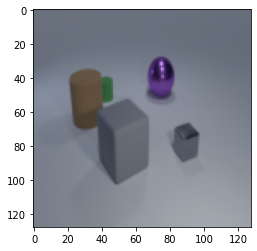

In [104]:
import matplotlib
import matplotlib.pyplot as plt


def inverse_normalize(tensor, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    tcopy = tensor.clone()
    for t, m, s in zip(tcopy, mean, std):
        t.mul_(s).add_(m)
    return tcopy
#img=img.squeeze(0)
print(img.size())
plt.imshow(inverse_normalize(img.cpu()).data[0].clip(0, 1).permute((1, 2, 0)));